In [29]:
# Initial imports
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from pathlib import Path
import pandas_datareader as web
import requests
from dotenv import load_dotenv
import os
import pprint
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
from ipynb.fs.full.pytrends_sentiment import generate_trends_analysis, generate_trends_analysis2, trend_analysis_expanded
from MCForecastTools import MCSimulation
import alpaca_trade_api as tradeapi

# Core Question

How can the tools we have learned for data analysis help us understand factors that correlate with the performance of world leading financial markets? And can we use these tools to uncover potentially unconventional correlations that could be used to inform investment decisions and create a diversified portfolio?

## Data Collection, Cleaning, and Organizing.
### Steps
1. Collect and clean financial data using a library called `pandas_datareader`
2. Import weather data from a csv file. This weather data was initially gathered froma a weather API called weatherbit.io. And due to API request limitations on historical weather data, we ran this data collection in a separate notebook. <<insert picture of code>>
- Insert picture of weather api code
3. Calculate the daily returns on the assets 
4. Combined into a dataframe called `combined_df`

In [30]:
# Generates the core dataframe used for analysis

# Read the Historical financial Data
historical_financial_df = web.get_data_yahoo(['^GSPC','CL=F','BTC-USD'], '10/31/2017', interval='d')
historical_financial_df = historical_financial_df.iloc[:, [0,1,2]]
historical_financial_df.dropna(inplace=True)

# Reads Weather Data and combining with dailly returns of the historical_financial_df
weather_data_path = Path('./Resources/weather_data_4years.csv')
weather_df = pd.read_csv(weather_data_path, index_col="Date", infer_datetime_format=True, parse_dates=True)

# Adds Average Temp Column
col = weather_df.loc[:,"High_Temp":"Low_Temp" ]
weather_df['Average_Temp'] = col.mean(axis=1)

# Create Daily Returns 
daily_returns = historical_financial_df.pct_change(fill_method='ffill')
daily_returns.dropna()

# Cleans column naming
daily_returns.columns = [' '.join(col).strip() for col in daily_returns.columns.values]
columns = ["sp_500", "WTI", "BTC"]
daily_returns.columns = columns

# Combines the daily returns with weather data
combined_df = pd.concat([daily_returns, weather_df['Average_Temp'],], axis="columns", join="inner")
combined_df.head()

# Display Sample
combined_df.head()

,sp_500,WTI,BTC,Average_Temp
Date,,,,
2018-10-31,0.010851,-0.013146,-0.002630,12.40
2018-11-01,0.010558,-0.024805,0.009524,16.60
2018-11-02,-0.006317,-0.008636,0.001671,19.00
2018-11-05,0.005600,-0.000634,0.004887,11.00
2018-11-06,0.006259,-0.014105,0.006441,12.95


### Question: Is there a measurable correlation between the weather in NYC and the performance of the market?
First attempt: generated an initial plot to so if there were any observable patterns could indicate a correlation

In [ ]:
# Create and view initial plot
combined_df.plot(title="Initial Data Plot")

### Assessment
NYC temperature obviously follows a predictable pattern over the course of 4 years
However the scale of daily returns is so small that its pretty challenging to observe any potential correletion.

When we rescale the daily retuns, it is still challenging to observe any relationships.


### If we isolate the S&P 500 and average temperature, what relationship do we observe?

In [ ]:
# Create and displays a plot 
combined_df.plot(x='sp_500', y= 'Average_Temp', style= 'o')
plt.xlabel ('^SP_500')
plt.ylabel ('Average_Temp')

### What does this graph tell us about the market performance / temperature correlation?
Since it may be hard to intuitively grasp the relationship, we also created a heatmap below to convey a quantified visual correlation.

In [ ]:
# Calculate and display de correlation matrix
correlation = combined_df.corr()
sns.heatmap(correlation, vmin=-1, vmax=1)

### Heatmap Analysis
The above heatmap shows show quantifiable figures indicating that weather is almost completely uncorrelated with the market as well as oil and BTC as specific assets.


## Question: Which of the factors in our initial data set is most correlated with the S&p 500?
The only observable correlations accoding to the heatmap is between the S&P 500 and BTC-USD. 
- Depending on the timeframe, we can see clear correlations by zooming in. For example, if we zoom into October 2022 the relationship is easy to observe.

In [ ]:
# Removes the oil column
sp500_btc_comparision = combined_df.drop(columns=['WTI'])

# Plots and displays the data 
sp500_btc_comparision.hvplot.line(
    x='Date',
    y=['sp_500', 'BTC'],
    xlabel='Date',
    ylabel="Daily Return",
    title="BTC / S&P 500 Comparison"
)

# Sentiment Analysis
### Does a relationship exist between the overall market performance and the sentiment of people's Google searches?
In order to answer this question we collected market data from a specific time period and google search trend data (using `pytrends` external library) from the same period, then ran a correlation analysis.

### Function created for reusability
`from ipynb.fs.full.pytrends_sentiment import generate_trends_analysis, generate_trends_analysis2`

Note: These functions look at the absolute price of the asset.

SPY:2022-09-01 2022-09-30
SPY:2022-10-01 2022-10-31
SPY:2022-11-01 2022-11-30


<AxesSubplot:title={'center':'SPY Daily Return Correlation with Sentiment Plot'}>

<AxesSubplot:title={'center':'SPY Daily Return Correlation with Sentiment Plot'}>

(None, None)

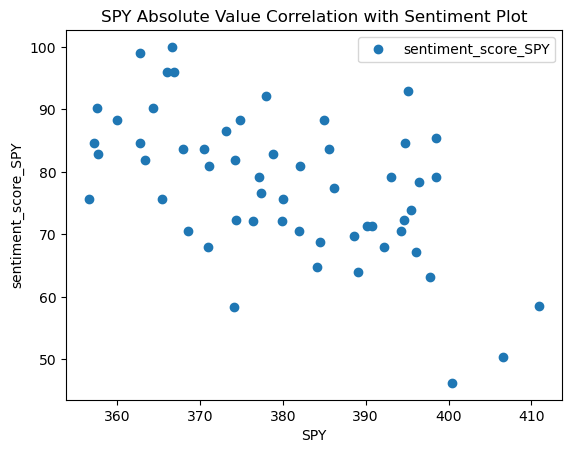

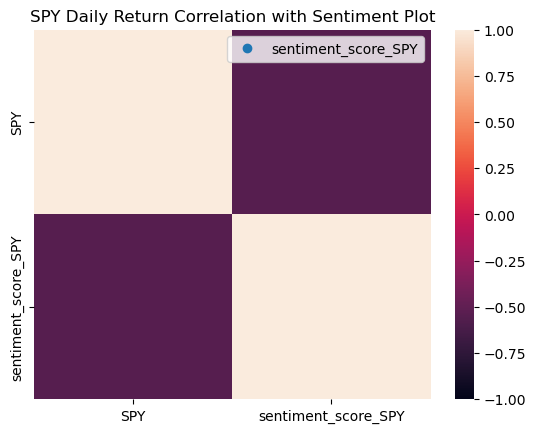

In [31]:
# S&P 500 index fund price plot with Google Trends sentiment score
generate_trends_analysis2('SPY')

BTC-USD:2022-09-01 2022-09-30
BTC-USD:2022-10-01 2022-10-31
BTC-USD:2022-11-01 2022-11-30


<AxesSubplot:title={'center':'BTC-USD Daily Return Correlation with Sentiment Plot'}>

<AxesSubplot:title={'center':'BTC-USD Daily Return Correlation with Sentiment Plot'}>

(None, None)

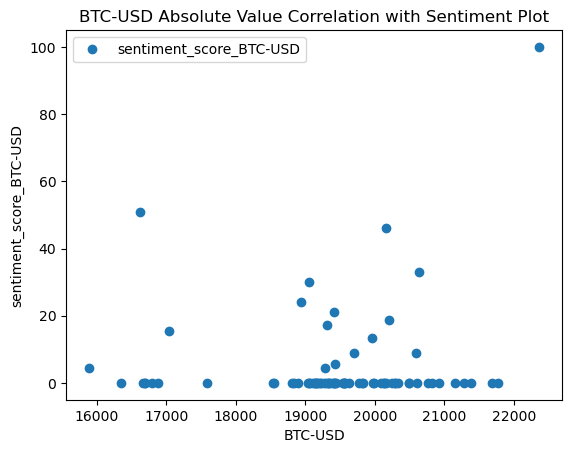

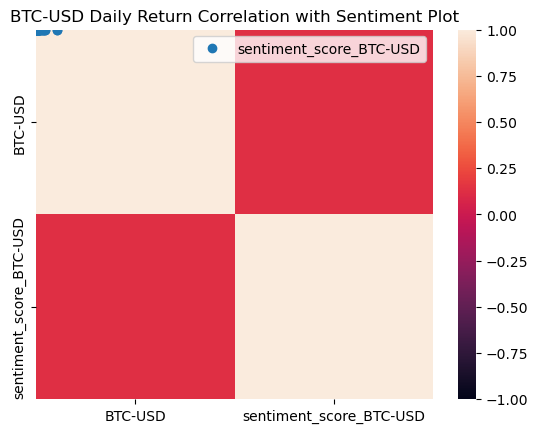

In [32]:
# Bitcoin price plot with Google Trends sentiment score
generate_trends_analysis2('BTC-USD')

In [ ]:
# Oil ETF price plot with Google Trends sentiment score
generate_trends_analysis2("CL=F")

# Analyis
- S&P 500: negatively correlated
- BTC: slightly negative
- Oil: neutral

## Additional Questions on Sentiment Analysis for forther investigatoin
- Our current analysis looks at the correlation between a given day's searches and the same day's asset value. If we were to stagger the days, would we see a deeper correlation?
- Since our analysis just looked at volume of searches, could a deeper look into what is being said reveal a deeper correlation? This would require a more sophisticated code that is able to perform NLP.
- Are there other search terms that correlate with the overall market performance or a specific asset's performance?

### Additional Trend Analysis demo
`trend_analysis_expanded(ticker, search_query)`

In [ ]:
# Displays correlations graphs for a variety of relationships

# Ukrainian War
# trend_analysis_expanded("SPY", "ukrainian war")
# trend_analysis_expanded("SPY", "russia")
# trend_analysis_expanded("SPY", "Vladimir Putin")
# trend_analysis_expanded("SPY", "Volodymyr Zelenskyy")
# trend_analysis_expanded("CL=F", "russia")

# Portfolio Analysis
### Question: Would a portfolio made up of SP500 index fund, BTC and Oil perform well over time?
An analysis of the the S&P 500, BTC, and WTI tells us that these three are have a low correlation. And generally when creating a portfolio, having uncorrelated assets is good. But we would want to know more about relative risk and potential return before investing.

To dive deeper into this question, we started with looking at:
- Cumulative returns
- Measures of risk including: 1) standard deviation, 2) bet, 3) sharpe ratios

In [ ]:
# Calculate cumulative returns of all portfolios
cumulative_returns = (1 + daily_returns).cumprod() - 1
# Plot cumulative returns
cumulative_returns.plot(
    title="Cumulative Returns",
    figsize=(20,10)
)

### Measures of Risk
- Volitility

In [ ]:
# Callculate the daily standard deviations as a measure of risk
assets_std = daily_returns.std().sort_values()
assets_std

In [ ]:
# Box plot to visually show risk
daily_returns.boxplot(figsize=(20,10))

In [ ]:
# callculate the rolling statandard deviation for 
rolling_21day_std_df = daily_returns.rolling(window=21).std()
# Plot the rolling standard deviation
rolling_21day_std_df.plot(figsize=(20,10))

### Beta tells us the risk relative to the overall market. 
- Calculated by dividing the covariance of an asset by the variance of the overall market."

In [ ]:
# Calculate covariance of a BTC
BTC_covariance = daily_returns["BTC"].rolling(window=60).cov(daily_returns["sp_500"])

# Calculate variance of S&P 500
variance = daily_returns["sp_500"].rolling(window=60).var()
# Computing beta
BTC_beta = BTC_covariance/variance
# Plot beta trend
BTC_plot = BTC_beta.plot(figsize=(20, 10))

# Calculate covariance of a WTI
WTI_covariance = daily_returns["WTI"].rolling(window=60).cov(daily_returns["sp_500"])
# Computing beta
WTI_beta = WTI_covariance/variance
# Plot beta trend
WTI_plot = WTI_beta.plot(figsize=(20, 10))

# Note BTC is in Blue and Oil is in Orange


### Sharpe Ratio
- Tells the reward relative to the risk compared the risk free rate

In [ ]:
# Annualized Sharpe Ratios
sharpe_ratios = (daily_returns.mean() * 252) / (assets_std * np.sqrt(252))

# Visualize the sharpe ratios as a bar plot
sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

In [33]:
# Load .env enviroment variables
load_dotenv()

# create alpaca api object
# Initializes the alpaca api object
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [34]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
mcs_start_date = pd.Timestamp('2017-10-29', tz='America/New_York').isoformat()
mcs_end_date = pd.Timestamp('2022-10-28', tz='America/New_York').isoformat()

# Set timeframe to "1Day"
timeframe = "1Day"

# Set the tickers
tickers = ['SPY','USO', 'BITO']

# crypto_tickers = ['BTCUSD']

# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start=mcs_start_date,
    end=mcs_end_date,
).df

# df_crypto_data = alpaca.get_crypto_bars(
#     crypto_tickers,
#     timeframe=timeframe,
#     start=mcs_start_date,
#     end=mcs_start_date,
# ).df


# Display sample data
df_stock_data.head()
# df_crypto_data.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2021-10-19 04:00:00+00:00,40.88,42.1500,40.07,41.94,24412914,262264,41.241761,BITO
2021-10-20 04:00:00+00:00,42.22,43.9500,42.10,43.28,29869163,283654,43.276052,BITO
2021-10-21 04:00:00+00:00,42.65,42.7900,40.41,40.83,20495021,207258,41.475489,BITO
2021-10-22 04:00:00+00:00,41.26,41.3029,38.90,39.51,11911259,118412,39.790983,BITO
2021-10-25 04:00:00+00:00,40.91,41.3090,40.53,40.58,7500649,61481,40.922194,BITO


In [35]:
# Reorganize the DataFrame
# Separate ticker data
SPY = df_stock_data[df_stock_data["symbol"]=="SPY"].drop("symbol", axis=1)
USO = df_stock_data[df_stock_data["symbol"]=="USO"].drop("symbol", axis=1)
CRYPTO = df_stock_data[df_stock_data["symbol"]=="BITO"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([SPY, USO, CRYPTO], axis=1, keys=["SPY", "USO", "BITO"])

df_stock_data.head()
# Display sample data
# df_stock_data.head()

SPY                                     \
                             open    high      low   close    volume   
timestamp                                                              
2017-10-30 04:00:00+00:00  257.07  257.60  256.410  256.80  54882217   
2017-10-31 04:00:00+00:00  257.18  257.44  256.805  257.12  60678916   
2017-11-01 04:00:00+00:00  258.04  258.43  257.070  257.50  54263336   
2017-11-02 04:00:00+00:00  257.41  257.75  256.190  257.62  56449535   
2017-11-03 04:00:00+00:00  257.77  258.50  257.300  258.45  62908639   

                                                     USO                  ...  \
                          trade_count        vwap   open    high     low  ...   
timestamp                                                                 ...   
2017-10-30 04:00:00+00:00      178943  257.065476  10.90  10.930  10.805  ...   
2017-10-31 04:00:00+00:00      162728  257.164535  10.85  10.960  10.830  ...   
2017-11-01 04:00:00+00:00      193085  257.717880  11.03  11.060  10.820  ...   
2017-11-02 04:00:00+00:00      217328  257.251675  10.90  11.005  10.871  ...   
2017-11-03 04:00:00+00:00      189765  258.119308  11.00  11.200  10.925  ...   

                                                           BITO           \
                             volume trade_count       vwap open high low   
timestamp                                                                  
2017-10-30 04:00:00+00:00  12586364       10577  10.861972  NaN  NaN NaN   
2017-10-31 04:00:00+00:00  14133224        9477  10.895818  NaN  NaN NaN   
2017-11-01 04:00:00+00:00  21152044       12490  10.949817  NaN  NaN NaN   
2017-11-02 04:00:00+00:00  10079321        6608  10.929011  NaN  NaN NaN   
2017-11-03 04:00:00+00:00  18851219       13330  11.079766  NaN  NaN NaN   

                                                         
                          close volume trade_count vwap  
timestamp                                                
2017-10-30 04:00:00+00:00   NaN    NaN         NaN  NaN  
2017-10-31 04:00:00+00:00   NaN    NaN         NaN  NaN  
2017-11-01 04:00:00+00:00   NaN    NaN         NaN  NaN  
2017-11-02 04:00:00+00:00   NaN    NaN         NaN  NaN  
2017-11-03 04:00:00+00:00   NaN    NaN         NaN  NaN  

[5 rows x 21 columns]

In [36]:
# Initializes the Monte Carlos Simulation object
MC_object = MCSimulation(
   portfolio_data = df_stock_data,
   weights = [1/3, 1/3, 1/3],
   num_simulation = 500,
   num_trading_days = 252*10
)

In [37]:
# Printing the simulation input data
MC_object.portfolio_data.head()

SPY                                     \
                             open    high      low   close    volume   
timestamp                                                              
2017-10-30 04:00:00+00:00  257.07  257.60  256.410  256.80  54882217   
2017-10-31 04:00:00+00:00  257.18  257.44  256.805  257.12  60678916   
2017-11-01 04:00:00+00:00  258.04  258.43  257.070  257.50  54263336   
2017-11-02 04:00:00+00:00  257.41  257.75  256.190  257.62  56449535   
2017-11-03 04:00:00+00:00  257.77  258.50  257.300  258.45  62908639   

                                                                  USO          \
                          trade_count        vwap daily_return   open    high   
timestamp                                                                       
2017-10-30 04:00:00+00:00      178943  257.065476          NaN  10.90  10.930   
2017-10-31 04:00:00+00:00      162728  257.164535     0.001246  10.85  10.960   
2017-11-01 04:00:00+00:00      193085  257.717880     0.001478  11.03  11.060   
2017-11-02 04:00:00+00:00      217328  257.251675     0.000466  10.90  11.005   
2017-11-03 04:00:00+00:00      189765  258.119308     0.003222  11.00  11.200   

                           ...                         BITO                 \
                           ...       vwap daily_return open high low close   
timestamp                  ...                                               
2017-10-30 04:00:00+00:00  ...  10.861972          NaN  NaN  NaN NaN   NaN   
2017-10-31 04:00:00+00:00  ...  10.895818     0.005520  NaN  NaN NaN   NaN   
2017-11-01 04:00:00+00:00  ...  10.949817    -0.002745  NaN  NaN NaN   NaN   
2017-11-02 04:00:00+00:00  ...  10.929011     0.008257  NaN  NaN NaN   NaN   
2017-11-03 04:00:00+00:00  ...  11.079766     0.017288  NaN  NaN NaN   NaN   

                                                                
                          volume trade_count vwap daily_return  
timestamp                                                       
2017-10-30 04:00:00+00:00    NaN         NaN  NaN          NaN  
2017-10-31 04:00:00+00:00    NaN         NaN  NaN          NaN  
2017-11-01 04:00:00+00:00    NaN         NaN  NaN          NaN  
2017-11-02 04:00:00+00:00    NaN         NaN  NaN          NaN  
2017-11-03 04:00:00+00:00    NaN         NaN  NaN          NaN  

[5 rows x 24 columns]

In [38]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_object.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\benei\FinTech\asset-correlation-analysis\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.192593,1.135000,0.932965,0.987381,0.924312,1.060413,0.907770,1.047256,0.875114,0.998679,...,0.999708,0.931736,1.002216,1.028153,1.065787,0.931728,1.063505,1.067013,1.020373,0.837644
2,1.179524,1.198689,0.904392,1.075894,0.972746,1.000148,1.021081,1.079509,0.868164,1.014271,...,0.931908,0.886510,1.047877,1.059281,1.060803,0.890581,1.010550,1.112936,0.871972,0.799318
3,1.227968,1.296532,0.831678,1.182737,0.958186,1.027266,1.071225,1.231724,0.875372,1.060020,...,0.872259,0.906463,0.935288,1.075416,1.188785,0.863057,1.069330,1.174057,0.795761,0.801441
4,1.284160,1.282865,0.832494,1.110751,0.983049,1.077676,1.207870,1.259449,0.908776,0.969671,...,0.824469,0.781124,0.955169,1.022957,1.034166,0.802542,1.044170,1.033017,0.775187,0.812888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,0.032016,0.001111,0.000122,0.047215,0.000107,0.113914,0.008398,0.004379,1.481934,0.084077,...,0.003266,0.182454,0.001677,0.001204,0.001858,39.168016,0.018653,0.002674,0.000034,0.024866
2517,0.032295,0.001195,0.000115,0.047246,0.000107,0.114508,0.007673,0.004807,1.445147,0.076132,...,0.003364,0.179590,0.001549,0.001143,0.001844,42.972758,0.018362,0.003090,0.000033,0.023388
2518,0.034166,0.001084,0.000105,0.043986,0.000097,0.112751,0.007665,0.004607,1.300185,0.076278,...,0.003235,0.192096,0.001386,0.001145,0.001934,40.330394,0.020350,0.003325,0.000031,0.025993
2519,0.034823,0.001063,0.000100,0.044020,0.000088,0.113050,0.007180,0.004552,1.388264,0.072960,...,0.003310,0.192969,0.001320,0.001052,0.001830,33.378144,0.020196,0.003427,0.000031,0.029653


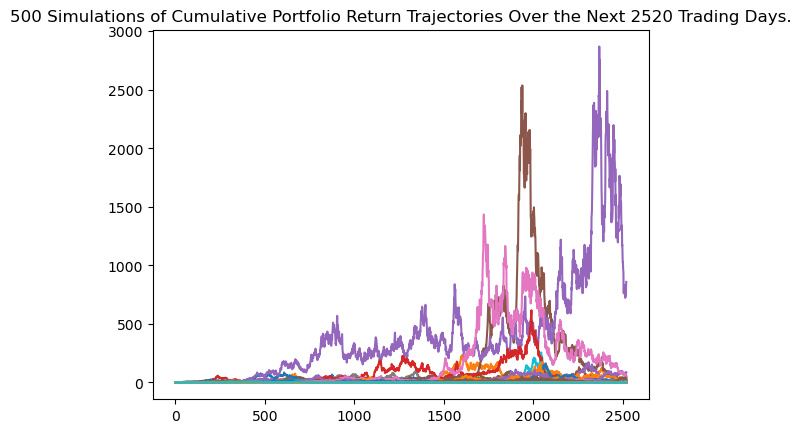

In [39]:
# Plot simulation outcomes
line_plot = MC_object.plot_simulation()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
mcs_summary = MC_object.summarize_cumulative_return()

# Print summary statistics
mcs_summary

In [ ]:
# Plot probability distribution and confidence intervals
dist_plot = MC_object.plot_distribution()

In [ ]:
# Set initial investment
initial_investment = 100000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(mcs_summary[8]*initial_investment,2)
ci_upper = round(mcs_summary[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

# Analysis

The S&P 500 has the least volitility as it is representative of the overall market performance. While conventional wisdom says BTC would be the riskier assets, the WTI oil ETF experienced a huge dip in the first half of 2020 (likely from the COVID-19 pandemic). As a reslut, oil ranks higher in volitilty than BTC.

`assets_std = daily_returns.std().sort_values()`

`sp_500    0.013608`

`BTC       0.047675`

`WTI       0.098946`

The Sharpe Ratios indicate that BTC has the highest upside. And despite it's high volitility, the reward outweighs the risk and it outperforms the market/S&P 500 on this metric. Oil on the other hand does not seem like a good asset to keep in the portfolio because 1) it has the highest volitily, 2)

## Question Restated: Would a portfolio made up of SP500 index fund, BTC and Oil be balanced and perform well over time?
Answer: Given the relative level that these assets are uncorrelated, combining them together in a portfolio could be a viable investment strategy. However, running a Monte Carlos simulation indicates that this would not be an advisable investment portfolio.

# Summary
- No correlation with market performance and weather
- Some assets' performance correlate with Google Trends sentiment scores, but not reliable indicator of performance
- Portfolio recommend: No

# Future analysis
Markowitz to determine ideal ratio of the assets in a portfolio